In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import sys
from datetime import datetime, timedelta
from geopy.distance import geodesic
from scipy.optimize import curve_fit

import sympy as sym
from sympy.plotting import plot
sym.init_printing(use_unicode=True)

x, y = sym.symbols('x y')

In [2]:
all = pd.read_csv("./data/wholetime.csv")

/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_25068/1049815730.py:1: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  all = pd.read_csv("./data/wholetime.csv")


In [4]:
"""
# start_lat_lngとend_lat_lngを小数点第5位までに丸める
# それぞれの値は緯度と経度を組み合わせたタプル
# それぞれをfloatに変換してから丸める
all['start_lat_lng'] = all['start_lat_lng'].apply(lambda x: tuple(map(float, x[1:-1].split(', '))))
all['end_lat_lng'] = all['end_lat_lng'].apply(lambda x: tuple(map(float, x[1:-1].split(', '))))
all['start_lat_lng'] = all['start_lat_lng'].apply(lambda x: tuple(map(lambda y: round(y, 5), x)))
all['end_lat_lng'] = all['end_lat_lng'].apply(lambda x: tuple(map(lambda y: round(y, 5), x)))
"""

"\n# start_lat_lngとend_lat_lngを小数点第5位までに丸める\n# それぞれの値は緯度と経度を組み合わせたタプル\n# それぞれをfloatに変換してから丸める\nall['start_lat_lng'] = all['start_lat_lng'].apply(lambda x: tuple(map(float, x[1:-1].split(', '))))\nall['end_lat_lng'] = all['end_lat_lng'].apply(lambda x: tuple(map(float, x[1:-1].split(', '))))\nall['start_lat_lng'] = all['start_lat_lng'].apply(lambda x: tuple(map(lambda y: round(y, 5), x)))\nall['end_lat_lng'] = all['end_lat_lng'].apply(lambda x: tuple(map(lambda y: round(y, 5), x)))\n"

In [3]:
all.head()

,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [4]:
# Get the node_list, edge_list and timestamp
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return node_list, edge_list, timestamp

In [5]:
all_nmt = return_nm(all)
all_nmt

(array([447, 468, 485, ..., 695, 713, 704]),
 array([ 2293,  2606,  3528, ..., 22434, 23771, 27678]),
 array([Timestamp('2020-04-01 00:00:30'), Timestamp('2020-04-02 00:00:30'),
        Timestamp('2020-04-03 00:00:30'), ...,
        Timestamp('2023-09-26 00:00:30'), Timestamp('2023-09-27 00:00:30'),
        Timestamp('2023-09-28 00:00:30')], dtype=object))

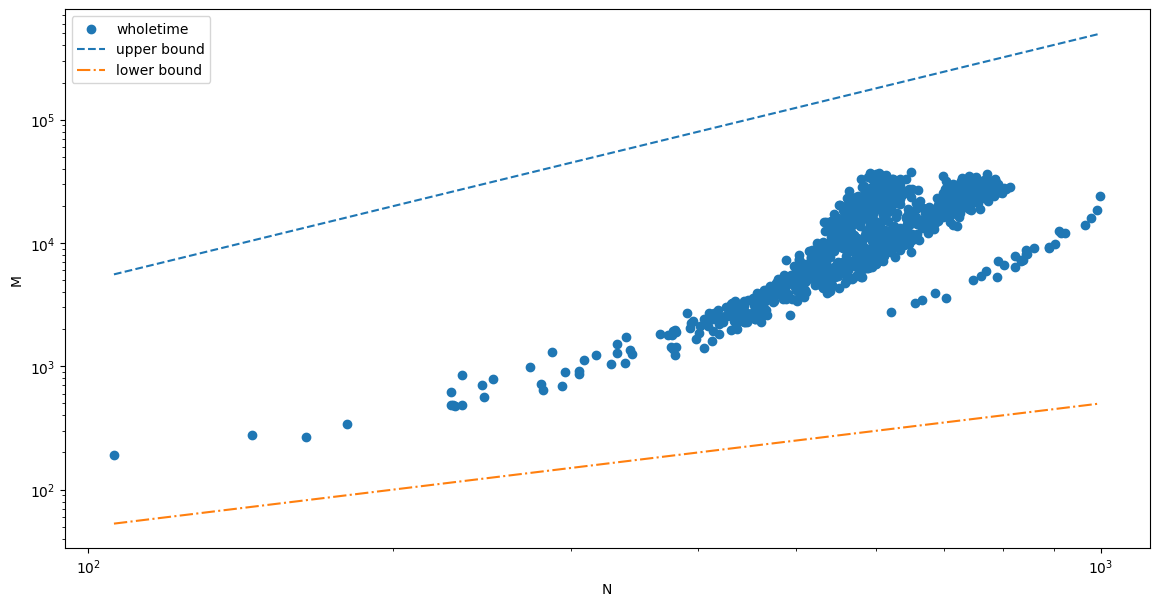

In [7]:
# node_list, edge_list, timestampをそれぞれ変数に代入
node_list = all_nmt[0]
edge_list = all_nmt[1]
timestamp = all_nmt[2]

nn = len(node_list)
xmin = min(node_list)
xmax = max(node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

# node_listとedge_listをプロット
plt.figure(figsize=(14, 7))
plt.scatter(node_list, edge_list, label="wholetime")
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel("N")
plt.ylabel("M")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()



/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_25068/1242465773.py:3: RuntimeWarning: invalid value encountered in sqrt
  a = (1+np.sqrt(1+(32*x/kappa)))/2


kappa: 2.0219269835469873e-05


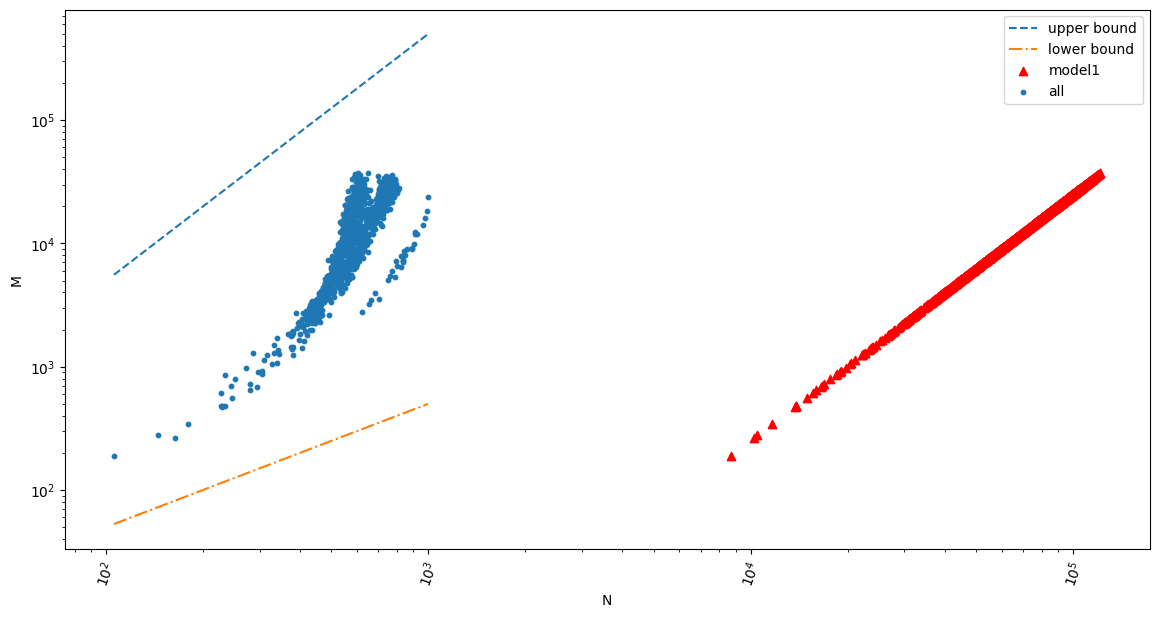

In [8]:
plt.figure(figsize=(14,7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
# 縦軸にNp, 横軸にNをとる
plt.scatter(Np, edge_list, label="model1", marker="^", c="red")
plt.scatter(node_list, edge_list, label="all", marker="o", s=10)
plt.xticks(rotation=70)
plt.xlabel("N")
plt.ylabel("M")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

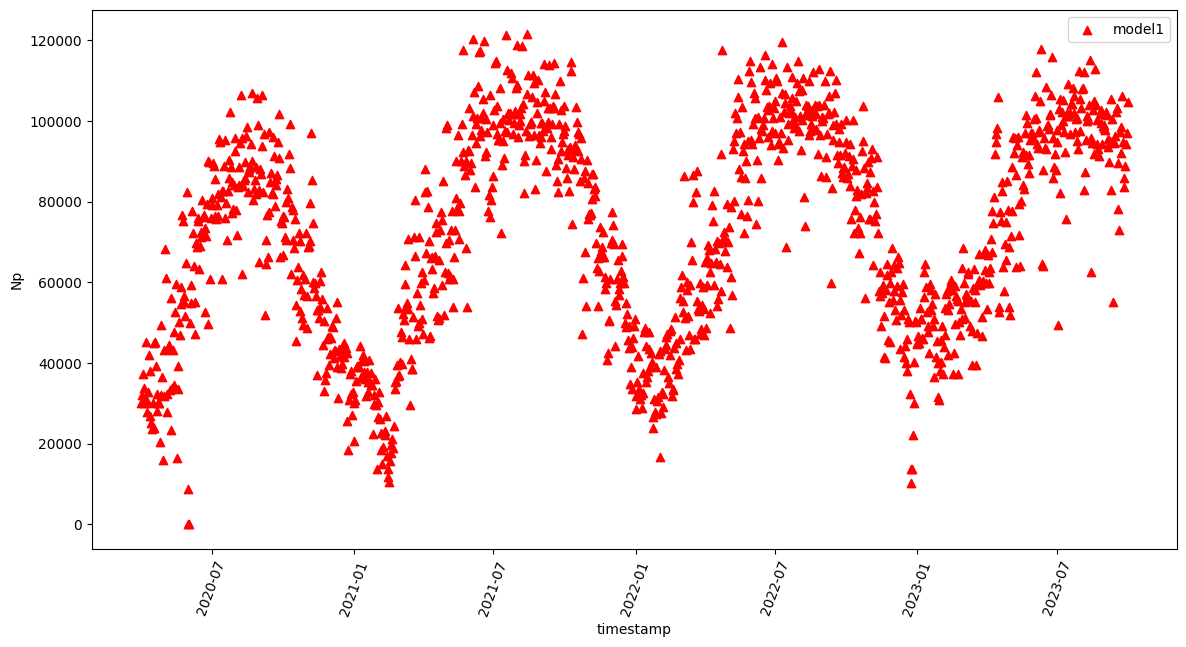

In [17]:
plt.figure(figsize=(14,7))
plt.scatter(timestamp, Np, label="model1", marker="^", c="red")
plt.xticks(rotation=70)
plt.xlabel("timestamp")
plt.ylabel("Np")
plt.legend()
plt.show()


/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_25068/3651663224.py:6: RuntimeWarning: divide by zero encountered in divide
  a = 8*x/(Np**2-Np)
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_25068/3651663224.py:8: RuntimeWarning: invalid value encountered in multiply
  return Np-2/a*((1-(1-(a/2))**Np))
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_25068/3651663224.py:8: RuntimeWarning: invalid value encountered in power
  return Np-2/a*((1-(1-(a/2))**Np))
/Users/ykaida/dev/chicago_master/venv/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_25068/3651663224.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  kappa.append(8*edge_list[i]/(Np**2-Np))


Np: 1.0


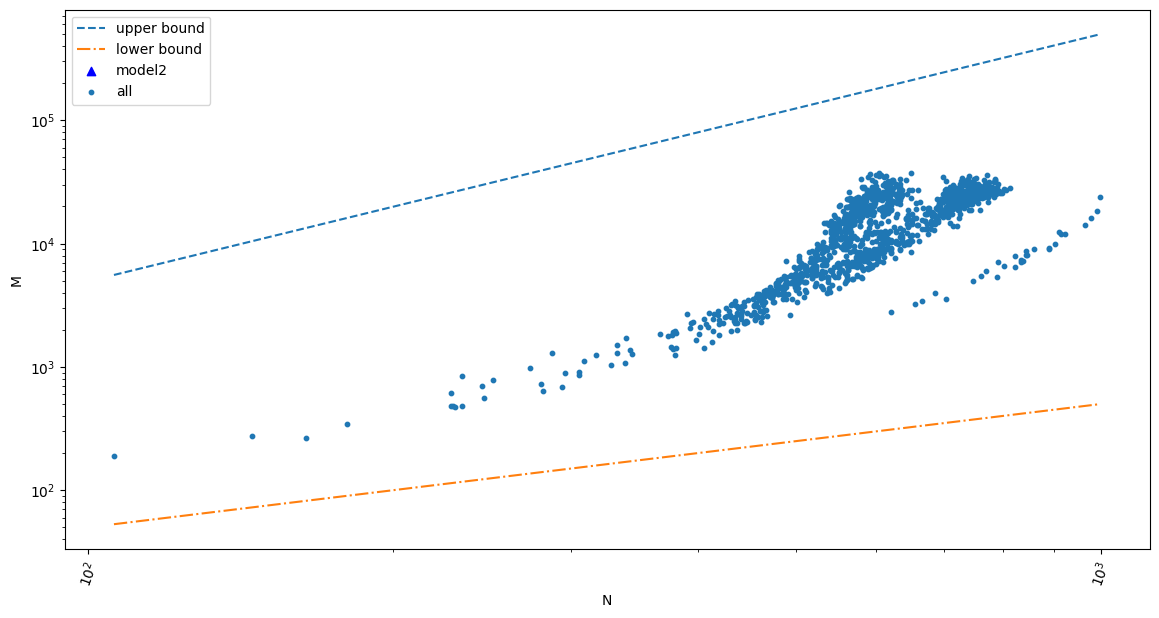

In [12]:
# node_listから0を削除
node_list = [x for x in node_list if x != 0]
edge_list = [x for x in edge_list if x != 0]

def model2(x, Np):
    a = 8*x/(Np**2-Np)
    try:
        return Np-2/a*((1-(1-(a/2))**Np))
    except:
        return 5


# フィッティングする
params, cov = curve_fit(model2, edge_list, node_list)
Np = params[0]
print("Np:", params[0])

# kappaを求める
kappa = []
for i in range(len(edge_list)):
    kappa.append(8*edge_list[i]/(Np**2-Np))

plt.figure(figsize=(14,7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
# 縦軸にNp, 横軸にNをとる
plt.scatter(node_list, kappa, label="model2", marker="^", c="blue")
plt.scatter(node_list, edge_list, label="all", marker="o", s=10)
plt.xticks(rotation=70)
plt.xlabel("N")
plt.ylabel("M")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_25068/3260902570.py:3: RuntimeWarning: invalid value encountered in sqrt
  a = (1 + np.sqrt((1 + 32*x/kappa)))/2


kappa: 6.715360927015586e-06


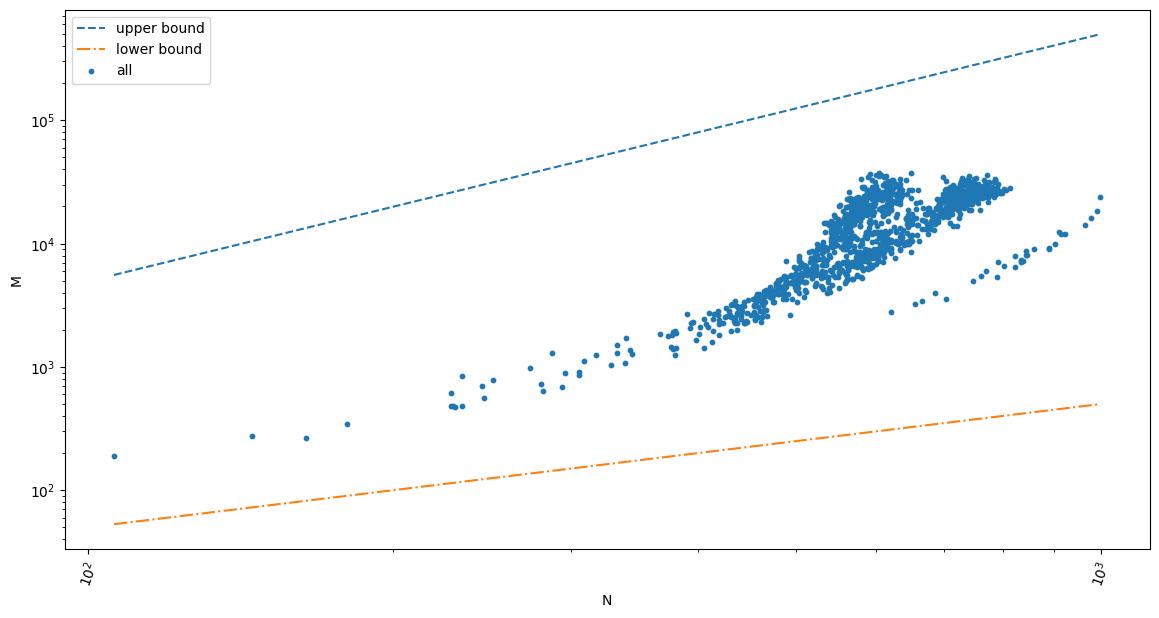

In [28]:
from scipy.optimize import curve_fit
def model1(x, kappa):
    a = (1 + np.sqrt((1 + 32*x/kappa)))/2
    res = a * (1 - 2/ (kappa * a) * (1 - (1 - kappa / 2)**a ))
    return res


# フィッティングする
popt, pcov = curve_fit(model1,node_list,edge_list)
kappa = popt[0]
print("kappa:", kappa)

# Npを求める
Np = []
for i in range(len(edge_list)):
    Np.append((1+np.sqrt(1+32*edge_list[i]/kappa))/2)

plt.figure(figsize=(14,7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
# 縦軸にedge_list, 横軸にnode_listをとる
plt.scatter(node_list, edge_list, label="all", marker="o", s=10)
plt.xticks(rotation=70)
plt.xlabel("N")
plt.ylabel("M")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_25068/985495422.py:5: RuntimeWarning: invalid value encountered in sqrt
  a = (1 + np.sqrt((1 + 32*x/kappa)))/2


kappa: 0.3303206986539506


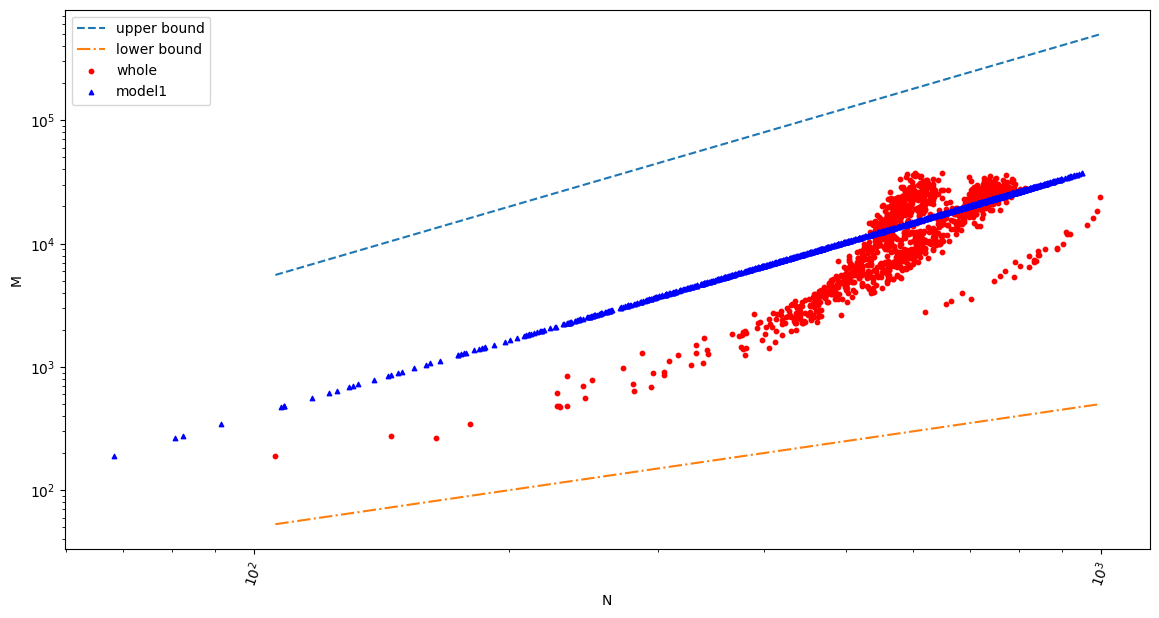

In [37]:
"""model1をきちんと計算する

"""
def model1(x, kappa):
    a = (1 + np.sqrt((1 + 32*x/kappa)))/2
    # aがRuntimeWarning: invalid value encountered in sqrtとなる場合がある
    # その場合はaを0にする
    if np.isnan(a.any()):
        a = 0
    res = a * (1 - 2/ (kappa * a) * (1 - (1 - kappa / 2)**a ))
    return res

M = edge_list
N = node_list

# フィッティングする
popt, pcov = curve_fit(model1,M,N)
kappa = popt[0]
print("kappa:", kappa)

# Npを求める
Np = []
for i in range(len(M)):
    Np.append((1 + np.sqrt( (1 + 32 * M[i]/kappa))) /2)

plt.figure(figsize=(14,7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
# 縦軸にedge_list, 横軸にnode_listをとる
plt.scatter(N, M, label="whole", marker="o", s=10, c="red")
plt.scatter(Np, M, label="model1", marker="^", c="blue", s=10)
plt.xticks(rotation=70)
plt.xlabel("N")
plt.ylabel("M")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()



/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_25068/4173977022.py:5: RuntimeWarning: invalid value encountered in power
  res = Np - ((Np ** 2 - Np))/4 * M * ((1 - (1 - ((4 * x) / (Np ** 2 - Np))) ** Np))


Np: 386.7127013914981


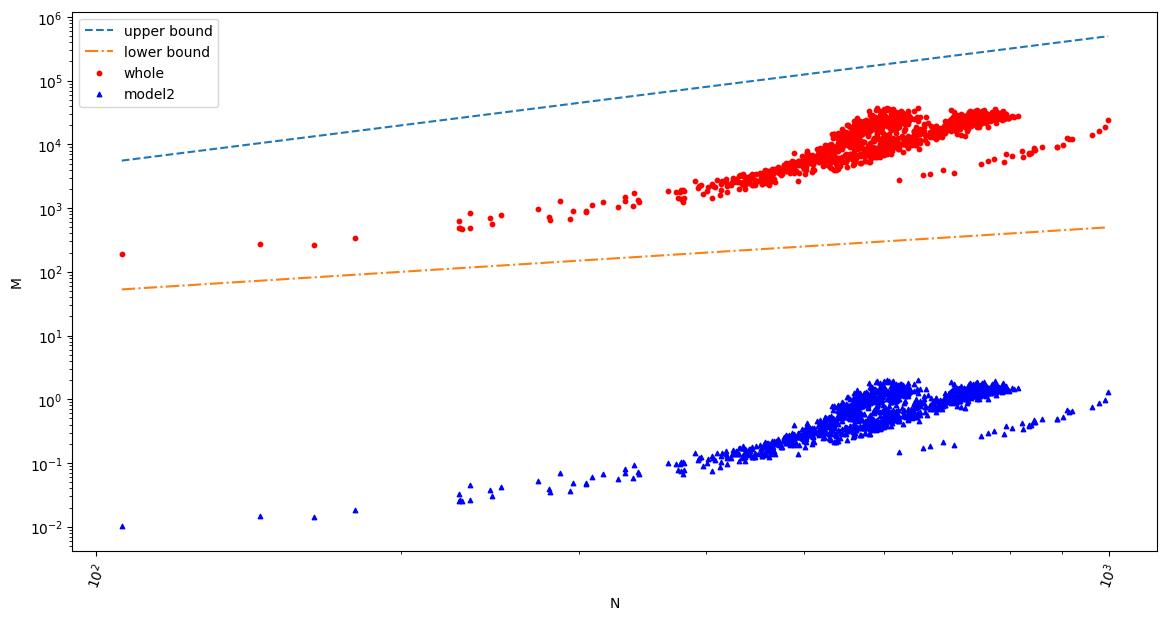

In [58]:
"""model2をきちんと計算する

"""
def model2(x, Np):
    res = Np - ((Np ** 2 - Np))/4 * M * ((1 - (1 - ((4 * x) / (Np ** 2 - Np))) ** Np))
    # resが0割りになってしまう場合があるので、その場合は0を返す
    if np.isnan(res.any()):
        res = 0
    if x.any() >= 0:
        return res
    else:
        return 0

M = np.array(edge_list)
N = np.array(node_list)

# フィッティングする
# boundsを設定する
popt, pcov = curve_fit(model2,M,N, bounds=(0, [1000]))
Np = popt[0]
print("Np:", Np)

# kappaを求める
kappa = []
for i in range(len(M)):
    kappa.append((8 * M[i]) / (Np ** 2 - Np))

plt.figure(figsize=(14,7))
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
# 縦軸にedge_list, 横軸にnode_listをとる
plt.scatter(N, M, label="whole", marker="o", s=10, c="red")
plt.scatter(N, kappa, label="model2", marker="^", c="blue", s=10)
plt.xticks(rotation=70)
plt.xlabel("N")
plt.ylabel("M")
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()



In [57]:
min(kappa)

In [48]:
type(M[1].astype(float))

numpy.float64

In [8]:
# allを用いて時期で分けてカーネル密度推定を行う
# まずは時期を分ける
all['started_at'] = pd.to_datetime(all['started_at'])
all['ended_at'] = pd.to_datetime(all['ended_at'])
all = all.sort_values(by='started_at')

# 2020年3月~2020年5月
all_202003_202005 = all[(all['started_at'] >= '2020-03-01') & (all['started_at'] < '2020-06-01')]

# 2020年6月~2020年8月
all_202006_202008 = all[(all['started_at'] >= '2020-06-01') & (all['started_at'] < '2020-09-01')]

# 2020年9月~2020年11月
all_202009_202011 = all[(all['started_at'] >= '2020-09-01') & (all['started_at'] < '2020-12-01')]

# 2020年12月~2021年2月
all_202012_202102 = all[(all['started_at'] >= '2020-12-01') & (all['started_at'] < '2021-03-01')]

# 2021年3月~2023年9月
all_202103_202309 = all[(all['started_at'] >= '2021-03-01') & (all['started_at'] < '2023-10-01')]

In [9]:
# 2020年3月~2020年5月のカーネル密度推定をseabornで行う
all_202003_202005_nmt = return_nm(all_202003_202005)

# 2020年6月~2020年8月のカーネル密度推定
all_202006_202008_nmt = return_nm(all_202006_202008)

# 2020年9月~2020年11月のカーネル密度推定
all_202009_202011_nmt = return_nm(all_202009_202011)

# 2020年12月~2021年2月のカーネル密度推定
all_202012_202102_nmt = return_nm(all_202012_202102)

# 2021年3月~2023年9月のカーネル密度推定
all_202103_202309_nmt = return_nm(all_202103_202309)

# node_list, edge_list, timestampをそれぞれ変数に代入
node_list_202003_202005 = all_202003_202005_nmt[0]
edge_list_202003_202005 = all_202003_202005_nmt[1]
timestamp_202003_202005 = all_202003_202005_nmt[2]

node_list_202006_202008 = all_202006_202008_nmt[0]
edge_list_202006_202008 = all_202006_202008_nmt[1]
timestamp_202006_202008 = all_202006_202008_nmt[2]

node_list_202009_202011 = all_202009_202011_nmt[0]
edge_list_202009_202011 = all_202009_202011_nmt[1]
timestamp_202009_202011 = all_202009_202011_nmt[2]

node_list_202012_202102 = all_202012_202102_nmt[0]
edge_list_202012_202102 = all_202012_202102_nmt[1]
timestamp_202012_202102 = all_202012_202102_nmt[2]

node_list_202103_202309 = all_202103_202309_nmt[0]
edge_list_202103_202309 = all_202103_202309_nmt[1]
timestamp_202103_202309 = all_202103_202309_nmt[2]

# node_listでkde


/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/389691087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['started_at'] = pd.to_datetime(df['started_at'])
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/389691087.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = pd.to_datetime(df['ended_at'])
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/389691087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [10]:
all_202103_202105 = all[(all['started_at'] >= '2021-03-01') & (all['started_at'] < '2021-06-01')]
all_202106_202108 = all[(all['started_at'] >= '2021-06-01') & (all['started_at'] < '2021-09-01')]
all_202109_202111 = all[(all['started_at'] >= '2021-09-01') & (all['started_at'] < '2021-12-01')]
all_202112_202202 = all[(all['started_at'] >= '2021-12-01') & (all['started_at'] < '2022-03-01')]
all_202203_202205 = all[(all['started_at'] >= '2022-03-01') & (all['started_at'] < '2022-06-01')]
all_202206_202208 = all[(all['started_at'] >= '2022-06-01') & (all['started_at'] < '2022-09-01')]
all_202209_202211 = all[(all['started_at'] >= '2022-09-01') & (all['started_at'] < '2022-12-01')]
all_202212_202302 = all[(all['started_at'] >= '2022-12-01') & (all['started_at'] < '2023-03-01')]
all_202303_202305 = all[(all['started_at'] >= '2023-03-01') & (all['started_at'] < '2023-06-01')]
all_202306_202309 = all[(all['started_at'] >= '2023-06-01') & (all['started_at'] < '2023-10-01')]

# return_nmを用いてnode_list, edge_list, timestampを取得
all_202103_202105_nmt = return_nm(all_202103_202105)
all_202106_202108_nmt = return_nm(all_202106_202108)
all_202109_202111_nmt = return_nm(all_202109_202111)
all_202112_202202_nmt = return_nm(all_202112_202202)
all_202203_202205_nmt = return_nm(all_202203_202205)
all_202206_202208_nmt = return_nm(all_202206_202208)
all_202209_202211_nmt = return_nm(all_202209_202211)
all_202212_202302_nmt = return_nm(all_202212_202302)
all_202303_202305_nmt = return_nm(all_202303_202305)
all_202306_202309_nmt = return_nm(all_202306_202309)

# node_list, edge_list, timestampをそれぞれ変数に代入
node_list_202103_202105 = all_202103_202105_nmt[0]
edge_list_202103_202105 = all_202103_202105_nmt[1]
timestamp_202103_202105 = all_202103_202105_nmt[2]

node_list_202106_202108 = all_202106_202108_nmt[0]
edge_list_202106_202108 = all_202106_202108_nmt[1]
timestamp_202106_202108 = all_202106_202108_nmt[2]

node_list_202109_202111 = all_202109_202111_nmt[0]
edge_list_202109_202111 = all_202109_202111_nmt[1]
timestamp_202109_202111 = all_202109_202111_nmt[2]

node_list_202112_202202 = all_202112_202202_nmt[0]
edge_list_202112_202202 = all_202112_202202_nmt[1]
timestamp_202112_202202 = all_202112_202202_nmt[2]

node_list_202203_202205 = all_202203_202205_nmt[0]
edge_list_202203_202205 = all_202203_202205_nmt[1]
timestamp_202203_202205 = all_202203_202205_nmt[2]

node_list_202206_202208 = all_202206_202208_nmt[0]
edge_list_202206_202208 = all_202206_202208_nmt[1]
timestamp_202206_202208 = all_202206_202208_nmt[2]

node_list_202209_202211 = all_202209_202211_nmt[0]
edge_list_202209_202211 = all_202209_202211_nmt[1]
timestamp_202209_202211 = all_202209_202211_nmt[2]

node_list_202212_202302 = all_202212_202302_nmt[0]
edge_list_202212_202302 = all_202212_202302_nmt[1]
timestamp_202212_202302 = all_202212_202302_nmt[2]

node_list_202303_202305 = all_202303_202305_nmt[0]
edge_list_202303_202305 = all_202303_202305_nmt[1]
timestamp_202303_202305 = all_202303_202305_nmt[2]

node_list_202306_202309 = all_202306_202309_nmt[0]
edge_list_202306_202309 = all_202306_202309_nmt[1]
timestamp_202306_202309 = all_202306_202309_nmt[2]


/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/389691087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['started_at'] = pd.to_datetime(df['started_at'])
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/389691087.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = pd.to_datetime(df['ended_at'])
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/389691087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [11]:
distance_202103_202105 = all_202103_202105['distance']
distance_202106_202108 = all_202106_202108['distance']
distance_202109_202111 = all_202109_202111['distance']
distance_202112_202202 = all_202112_202202['distance']
distance_202203_202205 = all_202203_202205['distance']
distance_202206_202208 = all_202206_202208['distance']
distance_202209_202211 = all_202209_202211['distance']
distance_202212_202302 = all_202212_202302['distance']
distance_202303_202305 = all_202303_202305['distance']
distance_202306_202309 = all_202306_202309['distance']

In [12]:
distance_202003_202005 = all_202003_202005["distance"]
distance_202006_202008 = all_202006_202008["distance"]
distance_202009_202011 = all_202009_202011["distance"]
distance_202012_202102 = all_202012_202102["distance"]


In [13]:
data_frames = [distance_202003_202005, distance_202006_202008, distance_202009_202011, distance_202012_202102, distance_202103_202105, distance_202106_202108, distance_202109_202111, distance_202112_202202, distance_202203_202205, distance_202206_202208, distance_202209_202211, distance_202212_202302, distance_202303_202305, distance_202306_202309]



/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/1278682791.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, label=label, bw_adjust=1.5)
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/1278682791.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, label=label, bw_adjust=1.5)
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/1278682791.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, label=label, bw_adjust=1.5)
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/1278682791.py:7: FutureWarning: 

`shade` is 

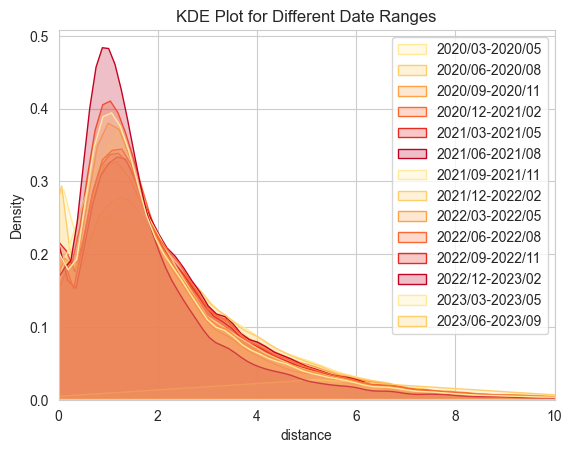

In [14]:
# グラフスタイルを設定
sns.set_style("whitegrid")
sns.set_palette("YlOrRd")

# グラフの作成
for data, label in zip(data_frames, ["2020/03-2020/05", "2020/06-2020/08", "2020/09-2020/11", "2020/12-2021/02", "2021/03-2021/05", "2021/06-2021/08", "2021/09-2021/11", "2021/12-2022/02", "2022/03-2022/05", "2022/06-2022/08", "2022/09-2022/11", "2022/12-2023/02", "2023/03-2023/05", "2023/06-2023/09"]):
    sns.kdeplot(data, shade=True, label=label, bw_adjust=1.5)

# x軸の範囲を指定
plt.xlim(0, 10)

# 凡例を表示
plt.legend()

# グラフのタイトルを設定
plt.title("KDE Plot for Different Date Ranges")

# グラフの背景色をカスタマイズ
# ax = plt.gca()
# ax.set_facecolor('whitesmoke')

# グラフを表示
plt.show()

/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/3639379393.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(j[0], shade=True, label=j[1], bw_adjust=1.5)
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/3639379393.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(j[0], shade=True, label=j[1], bw_adjust=1.5)
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/3639379393.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(j[0], shade=True, label=j[1], bw_adjust=1.5)
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/3639379393.py:5: FutureWarning: 

`shade` is now

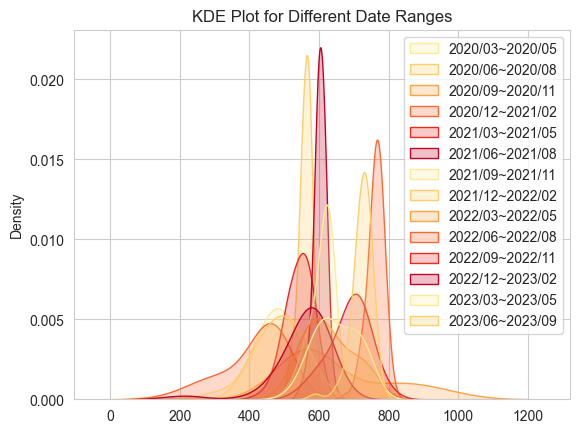

In [15]:
# node_listでkde
use_data = [node_list_202003_202005, node_list_202006_202008, node_list_202009_202011, node_list_202012_202102, node_list_202103_202105, node_list_202106_202108, node_list_202109_202111, node_list_202112_202202, node_list_202203_202205, node_list_202206_202208, node_list_202209_202211, node_list_202212_202302, node_list_202303_202305, node_list_202306_202309]
labels = ["2020/03~2020/05", "2020/06~2020/08", "2020/09~2020/11", "2020/12~2021/02", "2021/03~2021/05", "2021/06~2021/08", "2021/09~2021/11", "2021/12~2022/02", "2022/03~2022/05", "2022/06~2022/08", "2022/09~2022/11", "2022/12~2023/02", "2023/03~2023/05", "2023/06~2023/09"]
for j in zip(use_data, labels):
    sns.kdeplot(j[0], shade=True, label=j[1], bw_adjust=1.5)

# x軸の範囲を指定
# plt.xlim(0, 10)

# 凡例を表示
plt.legend()

# グラフのタイトルを設定
plt.title("KDE Plot for Different Date Ranges")

# グラフの背景色をカスタマイズ
# ax = plt.gca()
# ax.set_facecolor('whitesmoke')

# グラフを表示
plt.show()#



/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/389691087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['started_at'] = pd.to_datetime(df['started_at'])
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/389691087.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = pd.to_datetime(df['ended_at'])
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/389691087.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

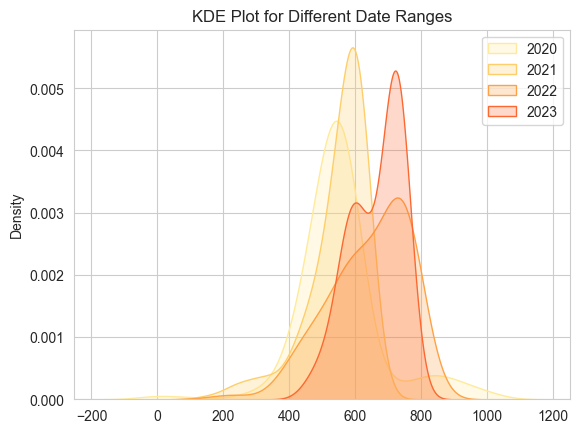

In [19]:
# allを年単位で分けてカーネル密度推定を行う
# まずは年単位に分ける
all['started_at'] = pd.to_datetime(all['started_at'])
all['ended_at'] = pd.to_datetime(all['ended_at'])
all = all.sort_values(by='started_at')

# 2020年
all_2020 = all[(all['started_at'] >= '2020-01-01') & (all['started_at'] < '2021-01-01')]
# 2021年
all_2021 = all[(all['started_at'] >= '2021-01-01') & (all['started_at'] < '2022-01-01')]
# 2022年
all_2022 = all[(all['started_at'] >= '2022-01-01') & (all['started_at'] < '2023-01-01')]
# 2023年
all_2023 = all[(all['started_at'] >= '2023-01-01') & (all['started_at'] < '2024-01-01')]

# return_nmを用いてnode_list, edge_list, timestampを取得
all_2020_nmt = return_nm(all_2020)
all_2021_nmt = return_nm(all_2021)
all_2022_nmt = return_nm(all_2022)
all_2023_nmt = return_nm(all_2023)

# node_list, edge_list, timestampをそれぞれ変数に代入
node_list_2020 = all_2020_nmt[0]
edge_list_2020 = all_2020_nmt[1]
timestamp_2020 = all_2020_nmt[2]

node_list_2021 = all_2021_nmt[0]
edge_list_2021 = all_2021_nmt[1]
timestamp_2021 = all_2021_nmt[2]

node_list_2022 = all_2022_nmt[0]
edge_list_2022 = all_2022_nmt[1]
timestamp_2022 = all_2022_nmt[2]

node_list_2023 = all_2023_nmt[0]
edge_list_2023 = all_2023_nmt[1]
timestamp_2023 = all_2023_nmt[2]

# node_listでkde
use_data = [node_list_2020, node_list_2021, node_list_2022, node_list_2023]
labels = ["2020", "2021", "2022", "2023"]
for j in zip(use_data, labels):
    sns.kdeplot(j[0], shade=True, label=j[1], bw_adjust=1.5)

# x軸の範囲を指定
# plt.xlim(0, 10)

# 凡例を表示
plt.legend()

# グラフのタイトルを設定
plt.title("KDE Plot for Different Date Ranges")

# グラフの背景色をカスタマイズ
# ax = plt.gca()
# ax.set_facecolor('whitesmoke')

# グラフを表示
plt.show()


/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/217402680.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, cmap=cmap, shade=True, label=label, bw_adjust=1.5)
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/217402680.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, cmap=cmap, shade=True, label=label, bw_adjust=1.5)
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/217402680.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, cmap=cmap, shade=True, label=label, bw_adjust=1.5)
/var/folders/n0/r52jwj117lx5t69xm0bw9b980000gn/T/ipykernel_8936/217402680.py

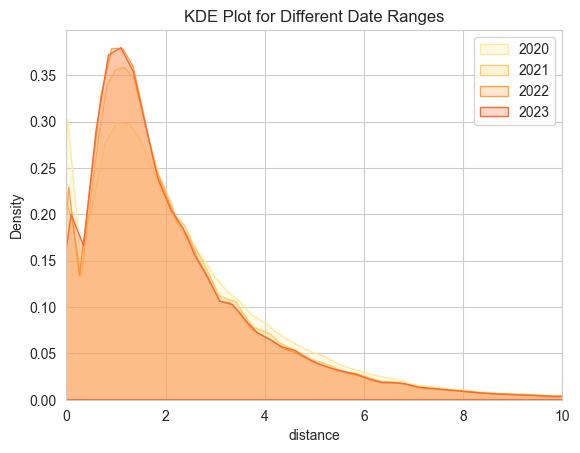

In [22]:
# allを年単位で分けて距離でカーネル密度推定を行う
# まずは年単位に分ける
all['started_at'] = pd.to_datetime(all['started_at'])
all['ended_at'] = pd.to_datetime(all['ended_at'])
all = all.sort_values(by='started_at')

# 2020年
all_2020_distance = all_2020['distance']
# 2021年
all_2021_distance = all_2021['distance']
# 2022年
all_2022_distance = all_2022['distance']
# 2023年
all_2023_distance = all_2023['distance']

# 距離は0~50kmで抑える
all_2020_distance = all_2020_distance[all_2020_distance < 50]
all_2021_distance = all_2021_distance[all_2021_distance < 50]
all_2022_distance = all_2022_distance[all_2022_distance < 50]
all_2023_distance = all_2023_distance[all_2023_distance < 50]

# グラフスタイルを設定
sns.set_style("whitegrid")
sns.set_palette("YlOrRd")

# カラーマップはわかりやすくする
cmap = sns.cubehelix_palette(as_cmap=True)


distance_year = [all_2020_distance, all_2021_distance, all_2022_distance, all_2023_distance]
# グラフの作成
for data, label in zip(distance_year, ["2020", "2021", "2022", "2023"]):
    sns.kdeplot(data, cmap=cmap, shade=True, label=label, bw_adjust=1.5)

# x軸の範囲を指定
plt.xlim(0, 10)

# 凡例を表示
plt.legend()

# グラフのタイトルを設定
plt.title("KDE Plot for Different Date Ranges")

# グラフの背景色をカスタマイズ
# ax = plt.gca()
# ax.set_facecolor('whitesmoke')

# グラフを表示
plt.show()


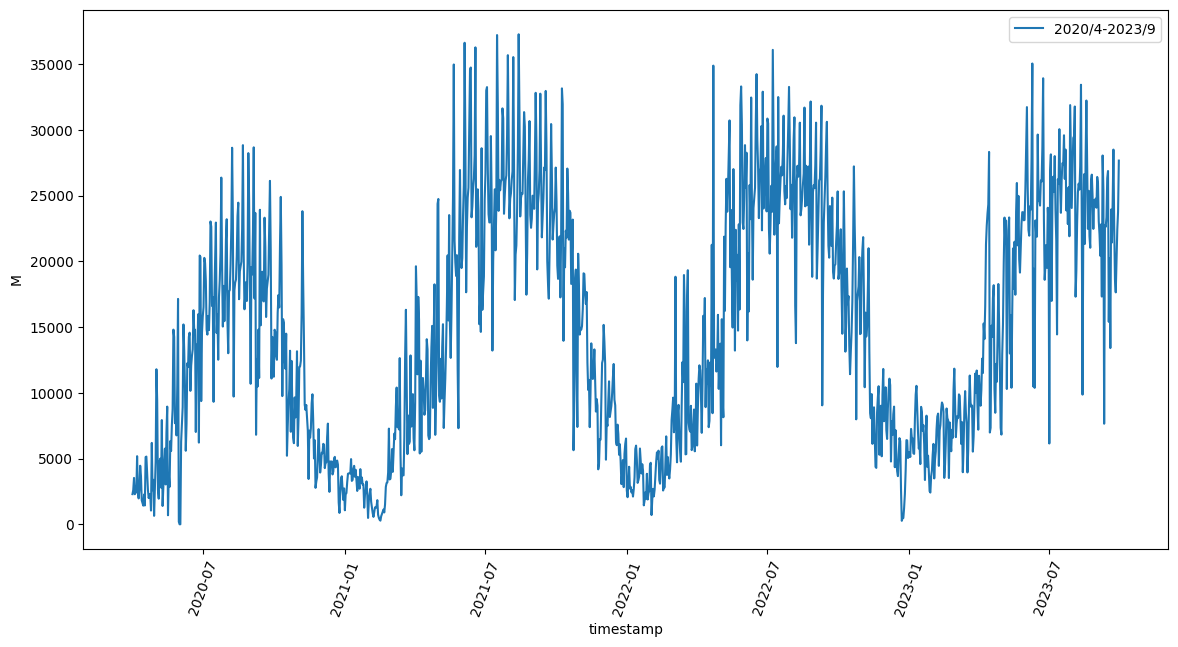

In [35]:
# x軸にタイムスタンプ、y軸にMをとる
plt.figure(figsize=(14,7))
plt.plot(all_nmt[2], all_nmt[1], label="2020/4-2023/9")
plt.xticks(rotation=70)
plt.xlabel("timestamp")
plt.ylabel("M")
plt.legend()
plt.show()

In [30]:
# node_listとedge_listで0がないか確認
print(node_list)
print(edge_list)


[447, 468, 485, 437, 465, 455, 505, 446, 431, 447, 471, 463, 420, 413, 406, 435, 381, 480, 498, 483, 457, 437, 445, 444, 328, 510, 441, 476, 281, 463, 500, 545, 526, 451, 414, 501, 499, 464, 504, 378, 467, 499, 521, 459, 520, 525, 294, 491, 461, 510, 513, 520, 519, 533, 539, 523, 539, 530, 543, 545, 106, 518, 517, 524, 541, 548, 547, 523, 525, 541, 548, 543, 550, 546, 547, 543, 550, 547, 536, 535, 519, 547, 550, 558, 517, 553, 552, 534, 553, 550, 572, 565, 561, 556, 563, 559, 562, 566, 559, 561, 566, 570, 569, 554, 565, 560, 563, 545, 568, 554, 560, 571, 566, 564, 563, 552, 567, 559, 573, 583, 565, 552, 565, 582, 569, 566, 565, 581, 568, 548, 569, 573, 576, 580, 573, 583, 574, 578, 579, 575, 577, 584, 579, 570, 569, 571, 565, 573, 582, 586, 584, 547, 590, 581, 586, 595, 564, 585, 535, 560, 560, 569, 555, 576, 579, 572, 576, 575, 567, 577, 581, 579, 585, 589, 586, 581, 589, 573, 542, 565, 568, 554, 554, 558, 562, 559, 568, 583, 581, 585, 592, 577, 541, 567, 568, 559, 545, 571, 488, 525,